In [1]:
import os
import ee
import xee
import geemap
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.signal import savgol_filter
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
import rioxarray
import subprocess
from shapely.geometry import Point

from func_mask import get_s2, add_cld_shdw_mask, apply_mask, addNDVI
from func_processing import time_series, extract_polygon_ts, bare_soil_calc


In [2]:
try:
    #ee.Initialize()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()

## Settings

In [3]:
# Voor twee jaar
start = '2021-11-01' # iets langer dan period of interest zodat we kunnen interpoleren
end = '2024-01-15'

start_wdw = '2022-02-01' # de echte period of interest
end_wdw = '2023-09-01'

vi_str = 'ndvi' # welke vegetatie-index
sg_filter = True # gebruik van een Savitzky-Golay filter 

output_folder = '../outputs/output_raster'
export = True

## Zenodo
Download csv with counting points from Zenodo, using an R script. The R script currently contains a placeholder file.

In [4]:
#-- Download
env = os.environ.copy()
env['R_LIBS'] = 'C:/R/library' # Asjust to folder where R libraries are installed

# Download directory
download_dir = os.path.join(os.getcwd(),'..','data','raw')

command = [
    "C:/R/R-4.4.1/bin/Rscript", # Asjust to version of R you want to run
    "func_telpunten_zenodo.R",
    download_dir
]

result = subprocess.run(command, capture_output=True, text=True, env=env)

print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)


STDOUT: [1] "File was downloaded"

STDERR: Will download 1 file (total size: 9.4 KiB) from https://doi.org/10.5281/zenodo.10890741 (Beaver territory locations in Flanders 2014-2019; version: 01/01/2020)


 Downloaded 2844 bytes...
 Downloaded 3503 bytes...
Verifying file integrity...

Beaver_territories.csv was downloaded and its integrity verified (md5sum: 2cd5b6bec7998f44d94136b6421cf8e7)



## Reading geometries
First convert csv with counting points to geodataferame with counting circles (r=300m).
Then clip the parcel data with this geodataframe.

<Axes: >

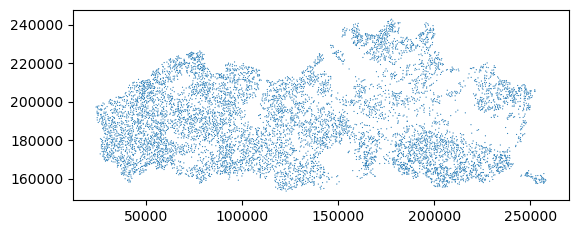

In [2]:
# Read the downloaded csv file with counting points
df_pts = pd.read_csv('../data/01-telpunten/steekproef_mbag_mas.csv')

# create GeoDataFrame
# Step 1: Create a 'geometry' column with Point geometries
df_pts['geometry'] = df_pts.apply(lambda row: Point(row['x_coord'], row['y_coord']), axis=1)
df_pts_crs = df_pts.crs[0]
df_pts = df_pts[['pointid', 'geometry']]

# Step 2: Convert the DataFrame to a GeoDataFrame
tc = gpd.GeoDataFrame(df_pts, geometry='geometry')

# Step 3: Set a coordinate reference system (CRS) (units should be in meters!!)
tc = tc.set_crs(epsg=int(df_pts_crs), inplace=True)

# Step 4: Buffer 300
tc = tc.buffer(300)


# Now df_pts is a GeoDataFrame with the original 'id' column
tc.plot()

In [4]:
tc.to_file('../data/processed/telpunten_processed.gpkg')

In [27]:
# Reading in all the parcels from Z-/Q-schijf
parcels = gpd.read_file('Q:/Projects/PRJ_MBAG/4a_mas/verzamelaanvraag/processed/landbouwgebruikspercelen_cut_bo_2022.gpkg')
parcels.head(5)

,GRAF_OPP,REF_ID,GWSCOD_V,GWSNAM_V,GWSCOD_H,GWSNAM_H,GWSGRPH_LB,GWSCOD_N,GWSNAM_N,GWSCOD_N2,...,STAT_AAR,PCT_EKBG,PRC_GEM,PRC_NIS,X_REF,Y_REF,WGS84_LG,WGS84_BG,jaar,geometry
0,2.0553,487348814,None,None,201,Silomaïs,Maïs,659,Mengsel van niet-vlinderbloemige groenbedekkers,None,...,None,None,Londerzeel,23045,143235.06,188742.47,"4°16'20""","51°0'31""",2022.0,"MULTIPOLYGON (((143130.120 188809.620, 143362...."
1,0.6188,922212948,None,None,201,Silomaïs,Maïs,None,None,None,...,None,None,Londerzeel,23045,143378.85,188592.97,"4°16'27""","51°0'27""",2022.0,"MULTIPOLYGON (((143340.950 188577.600, 143331...."
2,1.1995,1645633793,None,None,60,Grasland,Grasland,None,None,None,...,None,None,Londerzeel,23045,141859.51,188311.13,"4°15'9""","51°0'17""",2022.0,"MULTIPOLYGON (((141943.910 188298.470, 141943...."
3,0.9690,1747715381,None,None,201,Silomaïs,Maïs,None,None,None,...,None,None,Londerzeel,23045,141915.01,188252.16,"4°15'12""","51°0'15""",2022.0,"MULTIPOLYGON (((141826.940 188244.680, 141943...."
4,1.4954,2214827773,None,None,60,Grasland,Grasland,None,None,None,...,None,None,Londerzeel,23045,143179.87,188299.48,"4°16'17""","51°0'17""",2022.0,"MULTIPOLYGON (((143060.560 188405.660, 143063...."


In [30]:
parcels_clip = parcels.clip(tc)

In [ ]:

parcels_clip_leem = gpd.read_file(f'../data/03-percelen-clipped/steekproef_leemstreek_avimap_parcels.geojson')
parcels_clip_zandleem = gpd.read_file(f'../data/03-percelen-clipped/steekproef_zandleemstreek_avimap_parcels.geojson')
parcels_clip = pd.concat([parcels_clip_leem, parcels_clip_zandleem])
parcels_clip['geometry']= parcels_clip.geometry.to_crs('EPSG:4326')

# Spatial join to add pointid from tc to each parcel
gdf = parcels_clip.sjoin(tc)
gdf = gpd.GeoDataFrame(gdf, geometry = 'geometry').to_crs('EPSG:32631')

# Remove buildings
gdf = gdf.loc[gdf.GEWASGROEP != 'Landbouwinfrastructuur']
gdf.head(5)

In [6]:
# Welke velden liggen in twee telcirkels? Deze velden in twee delen voor berekening oppervlakte
gdf_to_split = gdf.loc[gdf.duplicated(subset = 'OIDN',keep = False)] # dit zijn de velden die in twee gesplitst moeten worden
#gdf_to_split.reset_index(drop=True).head(5)

# Create a dictionary to map plot IDs to geometries for faster access
plot_dict = tc.set_index('pointid')['geometry'].to_crs('EPSG:32631').to_dict()

# for some reason this does not work, so use a regular for-loop
#gdf_to_split.apply(
#    lambda row: row['geometry'].intersection(plot_dict[row['pointid']]),
#    axis=1)

ls = list()

for i in range(gdf_to_split.shape[0]):
    sample_pointid = gdf_to_split['pointid'].iloc[i]
    sample_geometry = gdf_to_split['geometry'].iloc[i]
    intersection_result = sample_geometry.intersection(plot_dict[sample_pointid])
    ls.append(intersection_result)

gdf_to_split.loc[:,'geometry'] = ls
#gdf_to_split.to_file('test.geojson')

gdf.loc[gdf.duplicated(subset = 'OIDN',keep = False), 'geometry'] = gdf_to_split['geometry']
#gdf.to_file('test_2.geojson')

# Fix geometries
gdf.loc[:,'geometry'] = gdf['geometry'].make_valid()

In [ ]:
#everything should be in crs 4326
# Step 5: CRS to 4326
tc = tc.to_crs(epsg=4326)

## Processing for-loop
- Getting time series
- Exporting them

In [8]:
# Loop over every telcirkel, for each one, data
sg_name = '_sg' if sg_filter == True else ''

for i in range(tc.shape[0]):
    # create a bbox and convert to right format for extracting time series
    pointid = tc.loc[i,'pointid']
    shape = tc.loc[i,'geometry']


    # Create time series with custom function
    da = time_series(start, end, start_wdw, end_wdw, shape, vi_arg = vi_str, sg = sg_filter) #input= 'EPSG:4326', output = 'EPSG:32631'
    da.rio.set_spatial_dims('X', 'Y', inplace=True)

    #-- EXPORT
    if export == True:
        # Rename dimensions to conform to rioxarray requirements
        da = da \
        .rename({'Y': 'y', 'X': 'x'}) \
        .transpose('time', 'y', 'x') \
        .rio.write_crs("EPSG:32631")


        # Specify the output file path & export as GTiff

        output_file = f'multiband_raster_{vi_str}_{pointid}{sg_name}.tif'
        output_path = os.path.join(output_folder, output_file)
        da.rio.to_raster(output_path, driver='GTiff', tiled=True, compress='LZW')

        # Band renaming with GDAL (to store the dates)
        gdal.UseExceptions()

        # Define band names (these should be in the order of your bands)
        band_names = [str(time).split('T')[0] for time in da.time.values]

        # Open the dataset in update mode
        dataset = gdal.Open(output_path, gdal.GA_Update)

        if dataset:
            for i, name in enumerate(band_names, start=1):
                band = dataset.GetRasterBand(i)
                if band:
                    band.SetDescription(name)  # Set the band name

            dataset = None  # Close the dataset to flush changes
        else:
            print("Error opening file")

crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631


## Bare soil analysis
Eerst de weggeschreven raster terug inladen op de juiste manier (time index valt onder andere weg blijkbaar). Daarna op de ingeladen data de *bare soil analysis* doen. De analyse op de weggeschreven rasters doen gaat veel sneller dan het rechtstreeks uit te voeren wanneer de data van earth engine komt!

In [9]:
#-- Polygon aggregation
# Create empty dataframe for storage results (polygon-aggregated time series)
df_ts = pd.DataFrame(columns=['OIDN', 'pointid', 'time', 'ndvi'])


raster_files = os.listdir(output_folder)

for file in raster_files:
    print(file)
    
    # Open the raster file
    raster = rioxarray.open_rasterio(os.path.join(output_folder,file))

    # Extract dates from the 'long_name' attribute, convert to datetime & assign to 'band' coordinate
    dates = [raster.attrs['long_name'][i] for i in range(len(raster.band))]
    time_index = pd.to_datetime(dates)
    raster['band'] = time_index


    # Xarray settings
    raster = raster.rename({'band': 'time', 'x' : 'X', 'y': 'Y'}).transpose('time', 'X', 'Y')
    raster = raster.rio.set_spatial_dims('X','Y')
    raster.rio.write_crs("EPSG:32631", inplace=True)

    #pointid moet overeenkomen met de raster waarvoor de data opgehaald wordt, anders probleem met geen overlap tussen raster en polygon
    if sg_filter == False:
        pointid = file.lstrip('multiband_raster_').rstrip('_test.tif')
    elif sg_filter == True:
        pointid = file.lstrip(f'multiband_raster_{vi_str}').rstrip('_sg.tif')
        
    gdf_agg = gdf.loc[gdf.pointid == pointid] #.to_crs('EPSG:32631') 

    for row in gdf_agg.itertuples():
        #print(row.geometry)
        crs = gdf.crs

        df_long = extract_polygon_ts(ts_array = raster, pd_row = row, buffer = -10, crs=crs)

        #df_ts.append(df_long)
        df_ts = pd.concat([df_ts, df_long], axis=0)

multiband_raster_ndvi_DM_386.7_sg.tif


C:\Users\kato_vanpoucke\AppData\Local\Temp\ipykernel_9760\1186638193.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ts = pd.concat([df_ts, df_long], axis=0)


Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_10274.7_sg.tif
Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_10276.12_sg.tif
Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_10626.4_sg.tif
Empty geometry
multiband_raster_ndvi_Lm_10976.1_sg.tif
Empty geometry
multiband_raster_ndvi_Lm_11070_sg.tif
Empty geometry
Empty geometry
Empty geometry
Empty geometry
Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_11568.1_sg.tif
Empty geometry
Empty geometry
Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_15064.9_sg.tif
Empty geometry
multiband_raster_ndvi_Lm_15493.7_sg.tif
Empty geometry
Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_15507.1.3_sg.tif
multiband_raster_ndvi_Lm_16499_sg.tif
Empty geometry
Empty geometry
Empty geometry
multiband_raster_ndvi_Lm_16502_sg.tif
Empty geometry
multiband_raster_ndvi_Lm_18391.2_sg.tif
Empty geometry
Empty geometry
Empty geometr

In [10]:
# Formatting before bare soil calculation
df_ts = df_ts.reset_index(drop=True).rename(columns = {'time': 'date'})
df_ts = df_ts.merge(gdf[['OIDN','pointid','geometry']], on = ['OIDN','pointid'], how = 'left')
gdf_ts = gpd.GeoDataFrame(df_ts, geometry='geometry')
df_ts.to_csv('../outputs/output_analysis/time_series.csv')

gdf_ts[['OIDN', 'pointid', 'date', 'ndvi','geometry']].head(3)
gdf.loc[~gdf.OIDN.isin(gdf_ts.OIDN.unique().tolist())].to_file('../outputs/empty_geometries.gpkg')

# Bare soil calculation
result = bare_soil_calc(gdf_ts) # Wel een groot verschil op het resultaat voor deze ene
result.to_csv('../outputs/output_analysis/bare_soil_analysis_v2.csv')
result.head(5)

,pointid,year,period,% bare soil
0,DM_386.7,2022,R1,41.157624
1,Lm_10274.7,2022,R1,48.342650
2,Lm_10276.12,2022,R1,54.148053
3,Lm_10626.4,2022,R1,22.957830
4,Lm_10976.1,2022,R1,46.958547


## Figuur

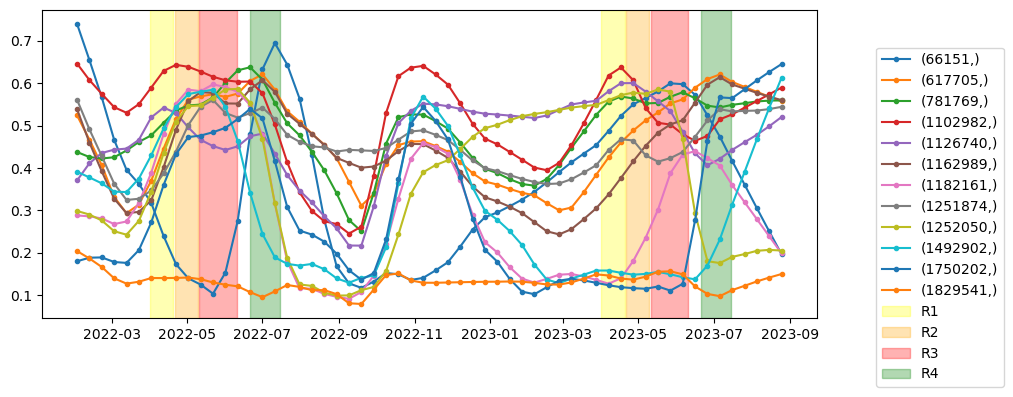

In [39]:
#df_ts = df_ts.set_index('date', inplace=False)
#df_ts.groupby('OIDN')['ndvi'].plot(legend=True)

fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df_ts.groupby(['OIDN']):
    ax.plot(grp['ndvi'], label=key, marker = '.')

for year in [2022,2023]:
    ax.axvspan(pd.to_datetime(f'{year}-04-01'), pd.to_datetime(f'{year}-04-20'), color='yellow', alpha=0.3, label='R1' if year == 2022 else None)
    ax.axvspan(pd.to_datetime(f'{year}-04-21'), pd.to_datetime(f'{year}-05-10'), color='orange', alpha=0.3, label='R2' if year == 2022 else None)
    ax.axvspan(pd.to_datetime(f'{year}-05-11'), pd.to_datetime(f'{year}-06-10'), color='red', alpha=0.3, label='R3' if year == 2022 else None)
    ax.axvspan(pd.to_datetime(f'{year}-06-21'), pd.to_datetime(f'{year}-07-15'), color='green', alpha=0.3, label='R4' if year == 2022 else None)
ax.legend(bbox_to_anchor=(0.75, 0.4, 0.5, 0.5))
plt.show()



#fig, ax =  plt.subplots()
#ax.plot(df_ts.gr[['date','ndvi']])

Tijdsreeksen *zien* er heel gelijkaardig uit: die in bare soil analysis zijn wel meer geëffend (omdat S-G filter gebruikt). Alleen wel raar dat de NDVI waarden zelf wel sterk lijken te verschillen. Met XEE krijg ik waarden tem 0.9, terwijl met de vorige methode, de waarden een stuk lager liggen. Mogelijk ligt het verschil aan de image collection: in the oudere methode gebruik ik S2_SR en nu gebruik ik S2_SR_Harmonized. De harmonized versie moet blijkbaar enkel gebruikt worden als je Landsat-8 ook gebruikt! dus overstappen op de S2_SR.

In [22]:
# TO DO
# Berekening total area veranderen: zorg dat de velden met empty geometries niet meegetellen 

## Plotting at a single location

In [ ]:
def savgol_filter_func(data, window_length=5, polyorder=2):
            return savgol_filter(data, window_length, polyorder)



# Apply Savitzky-Golay filter along the 'time' dimension
filtered_da = xarray.apply_ufunc(
    savgol_filter_func,  # Function to apply
    da,  # Input dataset
    input_core_dims=[['time']],  # Specify core dimensions
    dask='parallelized',  # Use parallelized computation if using dask arrays
    output_dtypes=[float],  # Output datatype
    output_core_dims=[['time']],
    vectorize=True,  # Vectorize the operation
    keep_attrs=True)  # Keep the original attributes of the dataset


filtered_da = filtered_da.transpose('time', 'Y', 'X')

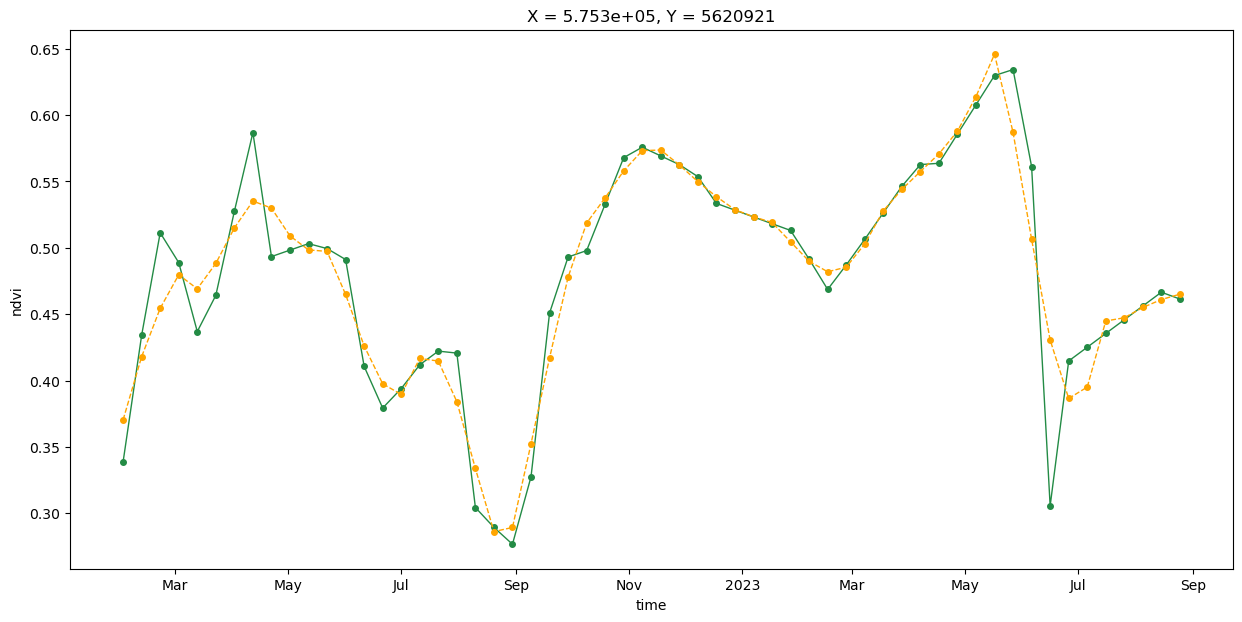

In [ ]:
#Example point for visualize the operation

point=[575290.79, 5620921]

#point[1]
X=point[0]
Y=point[1]


#original_ts = original_time_series.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)
#regular_ts = time_series_regular.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)
regular_ts = da.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)
filtered_ts = filtered_da.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)

# Plot figure
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

#original_ts.plot.line(
#    ax=ax, x='time',
#    marker='o', color='b', linestyle='-', linewidth=1, markersize=4)
regular_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
filtered_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='orange', linestyle='--', linewidth=1, markersize=4)

plt.show()

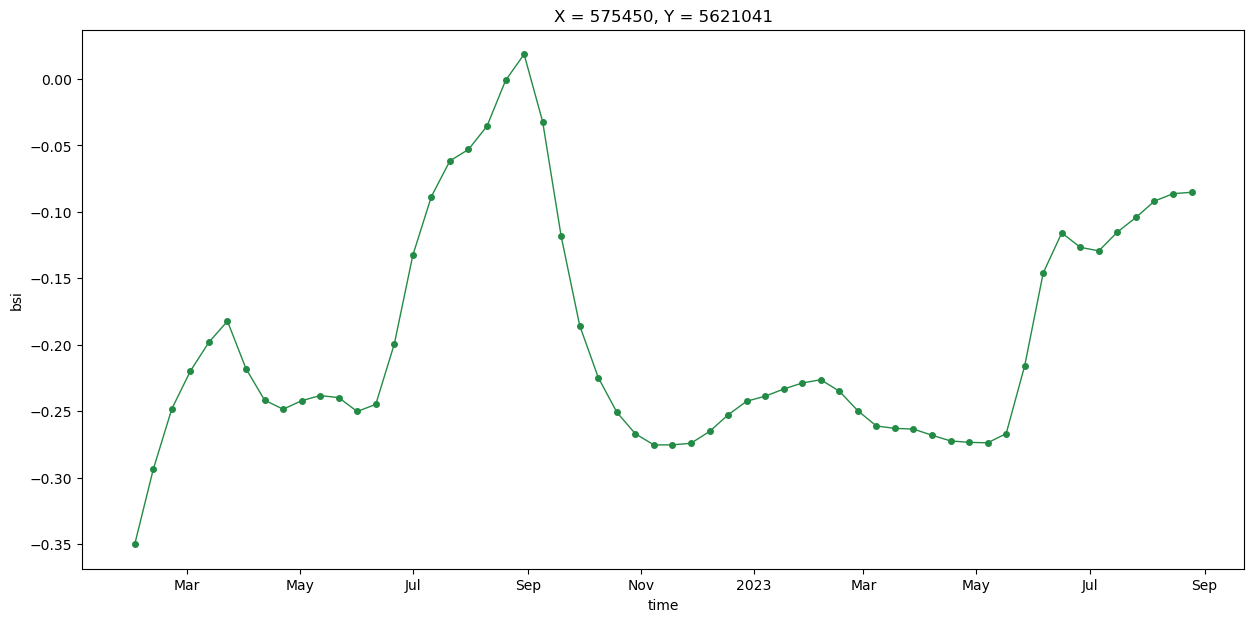

In [ ]:
#Example point for visualize the operation

point=[575450, 5621041]

#point[1]
X=point[0]
Y=point[1]


#original_ts = original_time_series.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)
#regular_ts = time_series_regular.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)
regular_ts = da.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)
#filtered_ts = filtered_da.dropna(dim = 'time', how = 'all').interp(X=X, Y=Y)

# Plot figure
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

#original_ts.plot.line(
#    ax=ax, x='time',
#    marker='o', color='b', linestyle='-', linewidth=1, markersize=4)
regular_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
#filtered_ts.plot.line(
#    ax=ax, x='time',
#    marker='o', color='orange', linestyle='--', linewidth=1, markersize=4)

plt.show()